In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import plotly.offline as po
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 200)

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('Terry_Stops.csv')

**Data Cleaning**

In [4]:
df['Precinct'] = df['Precinct'].replace(['SouthWest','-'], ['Southwest','Not Specified']) 
df = df[df.Precinct != 'OOJ']
df = df[df.Precinct != 'FK ERROR']
df = df[df.Precinct != 'Unknown']

df['Officer Race'] = df['Officer Race'].replace('Unknown', 'Not Specified')

df['Subject Perceived Race'] = df['Subject Perceived Race'].replace(['-', 'Unknown'],['Not Specified', 'Not Specified'])
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('-', 'Unknown')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('Unable to Determine', 'Gender Diverse (gender non-conforming and/or transgender)')

df['Call Type'] = df['Call Type'].replace('-','NOT SPECIFIED')

df['Year_of_Report'] = pd.to_datetime(df['Reported Date']).dt.year
df['Year_of_Report'] = df['Year_of_Report'].astype(int)

**First Feature Engineering**

In [5]:
#Creating the feature Arrested
df['Arrested'] = df['Stop Resolution'] == 'Arrest'
df['Arrested'] = df['Arrested'].replace([True, False], [1,0])

#Creating the feature White_Officer
df['White_Officer'] = (df['Officer Race'] == 'White')
df['White_Officer'] = df['White_Officer'].replace([True, False], [1,0])

#Creating the features Subject_POC
df['Subject_POC'] = df['Subject Perceived Race'] != 'White'
df['Subject_POC'] = df['Subject_POC'].replace([True, False], [1,0])

#Creating Hour, Morning, Afternoon, Evening and Night Features
df['Hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour
df['Hour'] = df['Hour'].replace(0,24)
df['Morning'] = (df['Hour'] >= 5) & (df['Hour'] < 12)
df['Morning'] = df['Morning'].replace([True,False], [1,0])
df['Afternoon']= (df['Hour'] >= 12) & (df['Hour'] < 17)
df['Afternoon'] = df['Afternoon'].replace([True,False], [1,0])
df['Evening'] = (df['Hour'] >= 17) & (df['Hour'] < 21)
df['Evening'] = df['Evening'].replace([True,False], [1,0])
df['Night'] = (df['Hour'] >= 21) & (df['Hour'] <= 24)
df['Night'] = df['Night'].replace([True,False], [1,0])

#Creating under_17 feature
df['under_17'] = df['Subject Age Group']=='1 - 17'
df['under_17'] = df['under_17'].replace([True, False], [1,0])


#Creating Officer Age Feature
df['Officer_Age'] = df['Year_of_Report'] - df['Officer YOB']
under_70 = df[df['Officer_Age']<= 70]
df['Officer YOB'] = df['Officer YOB'].astype(int)
mean_age = round(under_70['Officer_Age'].mean(), 0)
df['Officer_Age'] = df['Officer_Age'].replace([120,119,121,118,116,117,115],[mean_age,mean_age,mean_age,mean_age,mean_age,mean_age,mean_age])

#Creating weapon or not
df['Weapon'] = df['Weapon Type'] != 'None'
df['Weapon'] = df['Weapon'].replace([True,False],[1,0])

In [6]:
arrest_race = ['Subject Perceived Race','Arrested']

In [7]:
race = df[arrest_race]
race

,Subject Perceived Race,Arrested
0,White,1
1,Not Specified,0
2,White,0
3,White,0
4,Black or African American,1
...,...,...
46300,Black or African American,0
46301,Black or African American,0
46302,Hispanic,0
46303,Black or African American,0


In [8]:
race.groupby(['Subject Perceived Race']).sum()

,Arrested
Subject Perceived Race,
American Indian or Alaska Native,387
Asian,419
Black or African American,3809
Hispanic,398
Multi-Racial,162
Native Hawaiian or Other Pacific Islander,14
Not Specified,759
Other,40
White,5354


In [9]:
df.shape

(46054, 35)

In [10]:
dummy_df = pd.get_dummies(df, columns=['Subject Perceived Race','Stop Resolution',
                                       'Officer Race'],drop_first=True)

**Data Visualizations**

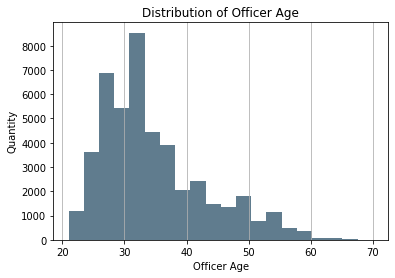

In [11]:
size, scale = 100, 10

df['Officer_Age'].plot.hist(grid=True, bins=20, rwidth=1,
                   color='#607c8e')
plt.title('Distribution of Officer Age')
plt.xlabel('Officer Age')
plt.ylabel('Quantity')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Stop Resolutions')

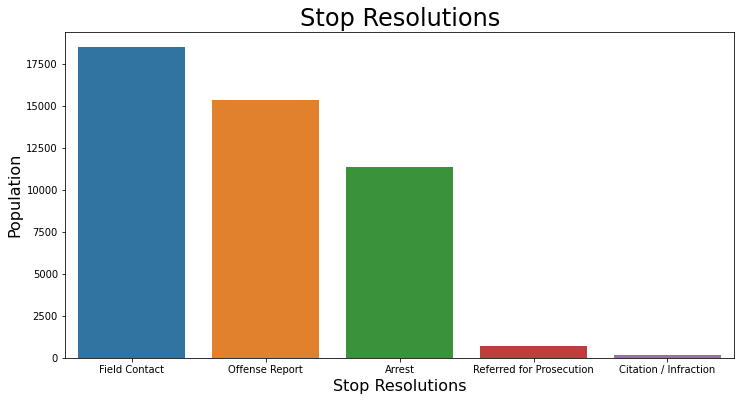

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
x = df['Stop Resolution'].value_counts().index
y = df['Stop Resolution'].value_counts()

sns.barplot(x=x, y=y, ax=ax, data=df)
plt.xlabel("Stop Resolutions", size=16)
plt.ylabel("Population", size=16)
plt.title("Stop Resolutions", size=24)

[[Text(0, 0, 'Not Arrested'), Text(1, 0, 'Arrested')]]

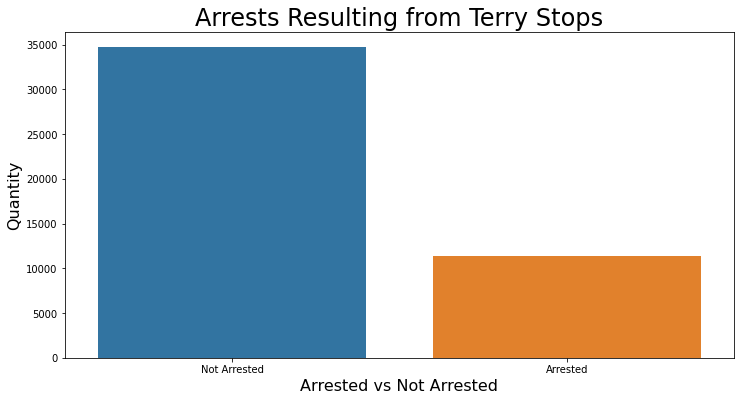

In [13]:
figure, axis = plt.subplots(figsize=(12,6))

sns.barplot(x=df['Arrested'].value_counts().index, y=df['Arrested'].value_counts())
plt.xlabel("Arrested vs Not Arrested", size=16)
plt.ylabel("Quantity", size=16)
plt.title('Arrests Resulting from Terry Stops', size=24)
axis.set(xticklabels=['Not Arrested','Arrested'])

Text(0.5, 1.0, 'Arrests Resulting from Terry Stops by Race')

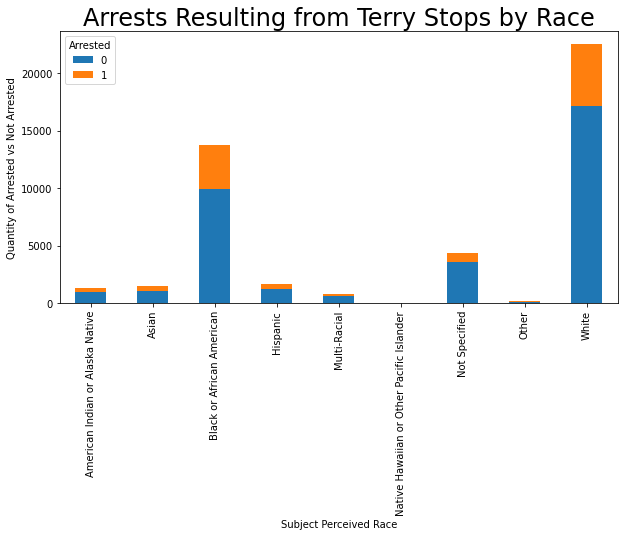

In [14]:
df.groupby(["Subject Perceived Race", "Arrested"]).size().unstack().plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel("Subject Perceived Race", size=10)
plt.ylabel("Quantity of Arrested vs Not Arrested", size=10)
plt.title('Arrests Resulting from Terry Stops by Race', size=24)

Text(0.5, 1.0, 'Stop Resolutions by Race')

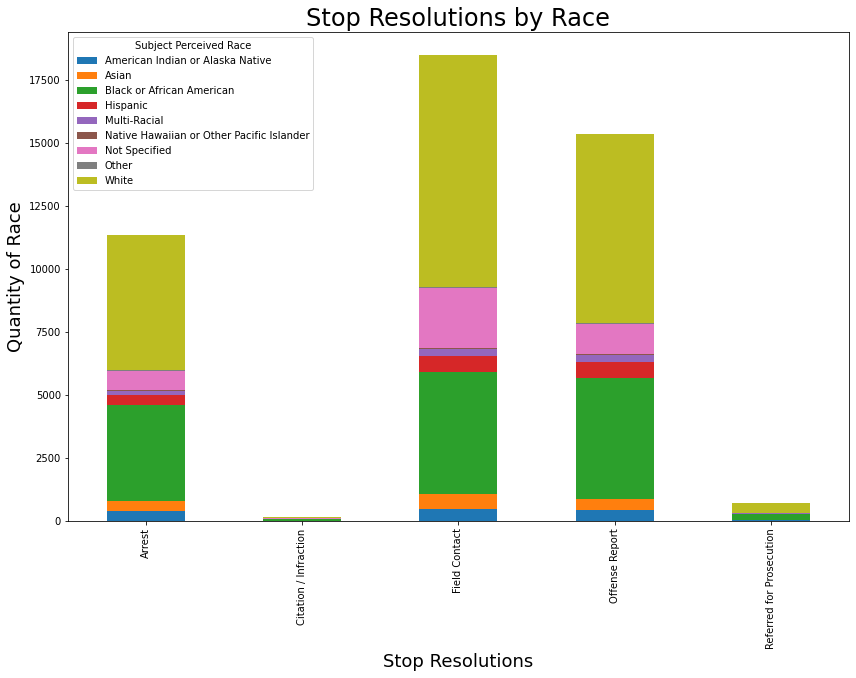

In [15]:
df.groupby(["Stop Resolution", "Subject Perceived Race"]).size().unstack().plot(kind='bar', stacked=True, figsize=(14,9))
plt.xlabel("Stop Resolutions", size=18)
plt.ylabel("Quantity of Race", size=18)
plt.title('Stop Resolutions by Race', size=24)

## Modeling


### Logistic Regression

### Baseline

In [16]:
features = ['Subject Perceived Race_Asian',
       'Subject Perceived Race_Black or African American',
       'Subject Perceived Race_Hispanic',
       'Subject Perceived Race_Multi-Racial',
       'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
       'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
       'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
       'Stop Resolution_Field Contact', 'Stop Resolution_Offense Report',
       'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
       'Officer Race_Black or African American',
       'Officer Race_Hispanic or Latino',
       'Officer Race_Nat Hawaiian/Oth Pac Islander',
       'Officer Race_Not Specified', 'Officer Race_Two or More Races',
       'Officer Race_White']

In [17]:
x_dummy = dummy_df[features]
y=df['Arrested']

In [18]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy,y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression().fit(X_train_dummy,y_train_dummy)
y_pred = logreg.predict(X_test_dummy)
accuracy_score(y_pred, y_test_dummy)

1.0

In [19]:
# experiment with random foorest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_dummy, y_train_dummy)
pred = rf.predict(X_test_dummy)
print(accuracy_score(pred, y_test_dummy))

1.0


feature:0, score: 0.00018
feature:1, score: 0.00160
feature:2, score: 0.00011
feature:3, score: 0.00026
feature:4, score: 0.00003
feature:5, score: 0.00249
feature:6, score: 0.00006
feature:7, score: 0.00084
feature:8, score: 0.00928
feature:9, score: 0.51061
feature:10, score: 0.43025
feature:11, score: 0.04285
feature:12, score: 0.00017
feature:13, score: 0.00018
feature:14, score: 0.00036
feature:15, score: 0.00019
feature:16, score: 0.00010
feature:17, score: 0.00031
feature:18, score: 0.00014


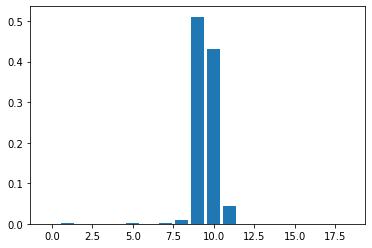

In [20]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
    print('feature:%0d, score: %.5f' %(i,v))
    
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [21]:
X_train_dummy.columns[9:11]

Index(['Stop Resolution_Field Contact', 'Stop Resolution_Offense Report'], dtype='object')

In [22]:
features2 = ['Subject Perceived Race_Asian',
       'Subject Perceived Race_Black or African American',
       'Subject Perceived Race_Hispanic',
       'Subject Perceived Race_Multi-Racial',
       'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
       'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
       'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
       'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
       'Officer Race_Black or African American',
       'Officer Race_Hispanic or Latino',
       'Officer Race_Nat Hawaiian/Oth Pac Islander',
       'Officer Race_Not Specified', 'Officer Race_Two or More Races',
       'Officer Race_White']

In [23]:
x2_dummy = dummy_df[features2]

In [24]:
X2_train_dummy, X2_test_dummy, y2_train_dummy, y2_test_dummy = train_test_split(x2_dummy,y, test_size = 0.3, random_state = 0)
logreg2 = LogisticRegression().fit(X2_train_dummy,y2_train_dummy)
y_pred2 = logreg2.predict(X2_test_dummy)
accuracy_score(y_pred2, y2_test_dummy)

0.7539263226460158

In [25]:
logged_odds = logreg2.intercept_
odds = np.exp(logged_odds)
probability = (odds/(1+odds))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [-1.09042788]


In [26]:
print(logreg2.coef_)
print(logreg2.intercept_)

[[ 0.00455007 -0.01633565 -0.27892236 -0.46133079 -0.06820233 -0.63470826
  -0.25010732 -0.2631748  -2.68999346 -3.81227325  0.11862576 -0.10053129
   0.11534603 -0.19244385  0.203284    0.27139679  0.2279069 ]]
[-1.09042788]


### Updated Model Logreg

In [27]:
both_dfdummy = pd.concat([df, dummy_df], axis=1)

In [53]:
features2 = ['Subject Perceived Race_Asian',
             'Subject Perceived Race_Black or African American',
             'Subject Perceived Race_Hispanic',
             'Subject Perceived Race_Multi-Racial',
             'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
             'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
             'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
             'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
             'Officer Race_Black or African American',
             'Officer Race_Hispanic or Latino',
             'Officer Race_Nat Hawaiian/Oth Pac Islander',
             'Officer Race_Not Specified', 'Officer Race_Two or More Races',
             'Officer Race_White','Weapon','White_Officer', 'under_17',
             'Morning', 'Afternoon', 'Evening', 'Night']

In [54]:
x_both = both_dfdummy[features2]

In [55]:
#Train test split
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(x_both,y, test_size = 0.3, random_state = 0)
logreg3 = LogisticRegression(class_weight='balanced').fit(X_test_both,y_test_both)
y_pred3 = logreg3.predict(X_test_both)
accuracy_score(y_pred2, y2_test_dummy)

0.7539263226460158

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_both, y_train_both)
pred = rf.predict(X_test_both)
print(accuracy_score(pred, y_test_both))

0.7516827097054354


feature:0, score: 0.04058
feature:1, score: 0.05985
feature:2, score: 0.04380
feature:3, score: 0.02493
feature:4, score: 0.00576
feature:5, score: 0.08308
feature:6, score: 0.01078
feature:7, score: 0.04901
feature:8, score: 0.01974
feature:9, score: 0.07615
feature:10, score: 0.03369
feature:11, score: 0.03057
feature:12, score: 0.03593
feature:13, score: 0.02556
feature:14, score: 0.03336
feature:15, score: 0.04205
feature:16, score: 0.00868
feature:17, score: 0.06173
feature:18, score: 0.08682
feature:19, score: 0.01159
feature:20, score: 0.01205
feature:21, score: 0.02258
feature:22, score: 0.02535
feature:23, score: 0.02191
feature:24, score: 0.01680
feature:25, score: 0.02039
feature:26, score: 0.01950
feature:27, score: 0.02105
feature:28, score: 0.01710
feature:29, score: 0.01729
feature:30, score: 0.02232


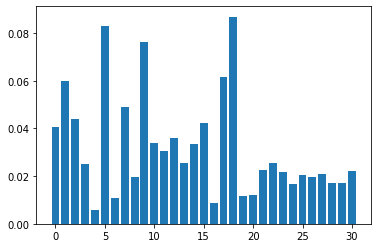

In [57]:
importance2 = rf.feature_importances_
for i,v in enumerate(importance2):
    print('feature:%0d, score: %.5f' %(i,v))
    
plt.bar([x for x in range(len(importance2))], importance2)
plt.show()

In [58]:
X_test_both.columns

Index(['Subject Perceived Race_Asian',
       'Subject Perceived Race_Black or African American',
       'Subject Perceived Race_Hispanic',
       'Subject Perceived Race_Multi-Racial',
       'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
       'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
       'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
       'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
       'Officer Race_Black or African American',
       'Officer Race_Hispanic or Latino',
       'Officer Race_Nat Hawaiian/Oth Pac Islander',
       'Officer Race_Not Specified', 'Officer Race_Two or More Races',
       'Officer Race_White', 'Weapon', 'Weapon', 'White_Officer',
       'White_Officer', 'under_17', 'under_17', 'Morning', 'Morning',
       'Afternoon', 'Afternoon', 'Evening', 'Evening', 'Night', 'Night'],
      dtype='object')

In [59]:
logged_odds2 = logreg3.intercept_
odds2 = np.exp(logged_odds2)
probability2 = (odds2/(1+odds2))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds2)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [0.34660285]


In [60]:
print(logreg3.coef_)
print(logreg3.intercept_)

[[-0.20026588 -0.19275255 -0.14497374 -0.40204687 -0.14779906 -0.8782136
   0.2012332  -0.32955863 -2.51345708 -3.65090036 -0.28134175 -0.36419584
  -0.08250375 -0.27590648 -0.15483795 -0.08426213 -0.02264938  0.17806151
   0.17806151 -0.02264938 -0.02264938 -0.08908376 -0.08908376  0.01496819
   0.01496819 -0.03645846 -0.03645846 -0.01347745 -0.01347745 -0.02338408
  -0.02338408]]
[0.34660285]


### Decision Tree

In [36]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(x_both, y, test_size=0.30, random_state=0)

In [37]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
y_pred_dt = classifier.predict(X_test_dt)
accuracy_score(y_pred_dt, y_test_dt)

0.7330100600709272

**Model Evaluation**

In [39]:
dt_cm = confusion_matrix(y_test_dt, y_pred_dt)
print(dt_cm)
print(classification_report(y_test_dt, y_pred_dt))

[[9796  621]
 [3068  332]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     10417
           1       0.35      0.10      0.15      3400

    accuracy                           0.73     13817
   macro avg       0.55      0.52      0.50     13817
weighted avg       0.66      0.73      0.67     13817



Text(0.5, 1.0, 'Desicion Tree Confusion Matrix')

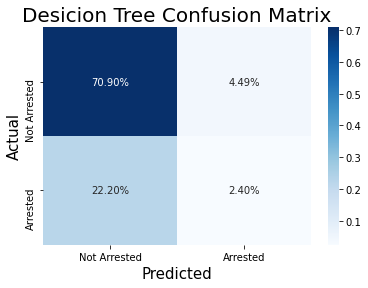

In [75]:
categories = ['Not Arrested','Arrested']
sns.heatmap(dt_cm/np.sum(dt_cm), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted",size=15, loc='center')
plt.ylabel("Actual",size=15, loc='center')
plt.title('Desicion Tree Confusion Matrix',size=20)

In [62]:
lr_cm = confusion_matrix(y_test_both, y_pred3)
print(lr_cm)
print(classification_report(y_test_both, y_pred3))

[[5780 4637]
 [1481 1919]]
              precision    recall  f1-score   support

           0       0.80      0.55      0.65     10417
           1       0.29      0.56      0.39      3400

    accuracy                           0.56     13817
   macro avg       0.54      0.56      0.52     13817
weighted avg       0.67      0.56      0.59     13817



Text(0.5, 1.0, 'LogReg Confusion Matrix')

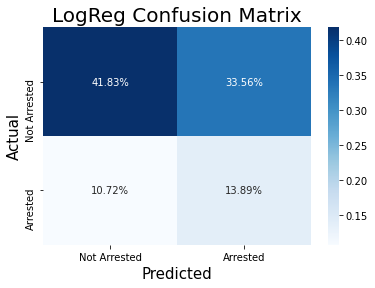

In [71]:
categories = ['Not Arrested','Arrested']
sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)

plt.xlabel("Predicted",size=15)
plt.ylabel("Actual",size=15)
plt.title('LogReg Confusion Matrix',size=20)